<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/Scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
#!pip3 install pandasql
import pandasql as pdsql
from google.colab import drive
# drive.mount('/content/drive')

In [0]:
class Scorecard:
  # PDO - Points to double
  # https://zhuanlan.zhihu.com/p/29776029
  def __init__(self, P0, pointsToDouble, p):
    self.P0 = P0
    self.pointsToDouble = pointsToDouble
    self.p = p
    odds = p/(1.0-p)
    self.B = pointsToDouble / math.log(2.0)
    self.A = P0 + self.B * math.log(odds)
    
  def score(self, p):
    return self.A - self.B * math.log(p/(1-p))

In [0]:
class FeatureProcessor:
  # formula taken from following link:
  # http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/
  def woe(self, df, binCol, totNumCol, badNumCol):
    result = pd.DataFrame([], columns={
      "bin_id",
      "tot_num","tot_good_num","tot_bad_num",
      "all_num", "good_num","bad_num",
      "dist_good", "dist_bad",
      "weight_of_evidence", "info_val"})    
    totNum = df.loc[:,totNumCol].sum()
    badNum = df.loc[:,badNumCol].sum()
    goodNum = totNum - badNum
    
    for i in range(len(df2.index)):
      distGood = (df.loc[:,totNumCol][i] - df.loc[:,badNumCol][i]) / totNum
      distBad = df.loc[:,badNumCol][i] / totNum
      result = result.append({
        "bin_id": df.loc[:,binCol][i],
        "tot_num": totNum,
        "tot_good_num": goodNum,
        "tot_bad_num": badNum,
        "all_num": df.loc[:,totNumCol][i],
        "good_num": (df.loc[:,totNumCol][i] - df.loc[:,badNumCol][i]),
        "bad_num": df.loc[:,badNumCol][i],
        "dist_good": distGood,
        "dist_bad": distBad,
        "weight_of_evidence": math.log(distGood / distBad), 
        "info_val":(distGood - distBad) * math.log(distGood / distBad)},
        ignore_index=True
      )
    iv = result.loc[:,"info_val"].sum()
    return result, iv
  
  def intepret_iv(self, iv):
    ivRange = [
      [0,    0.02, "Useless for prediction"],
      [0.02, 0.1,  "Weak predictor"],
      [0.1,  0.3,  "Medium predictor"],
      [0.3,  0.5,  "Strong predictor"],
      [0.5,  "+",  "Suspicious or too good to be true"]]
    for i in range(len(ivRange)):
      if i != len(ivRange)-1:
        if iv >= ivRange[i][0] and iv < ivRange[i][1]:
          return ivRange[i][2]
      else:
        if iv >= ivRange[i][0]:
          return ivRange[i][2]
    return "Invalid"

In [88]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
df = pd.read_csv("/content/drive/My Drive/creditcard_model/data/bank.csv", delimiter=";")
df2 = pdsql.sqldf("""
SELECT
   ROUND(age/10,0) bin,
   COUNT(1) AS total_num,
   SUM(CASE
      WHEN y='yes' THEN 1
      ELSE 0
   END) AS bad_num
FROM df
GROUP BY ROUND(age/10,0)
""")
df2.head(10)

,bin,total_num,bad_num
0,1.0,4,2
1,2.0,478,72
2,3.0,1808,185
3,4.0,1203,123
4,5.0,854,84
5,6.0,113,31
6,7.0,47,18
7,8.0,14,6


In [84]:
fp = FeatureProcessor()
woeDf, iv = fp.woe(df2, 'bin', 'total_num', 'bad_num')
woeDf[["bin_id",
      "tot_num","tot_good_num","tot_bad_num",
      "all_num", "good_num","bad_num",
      "dist_good", "dist_bad",
      "weight_of_evidence", "info_val"]]

,bin_id,tot_num,tot_good_num,tot_bad_num,all_num,good_num,bad_num,dist_good,dist_bad,weight_of_evidence,info_val
0,1.0,4521.0,4000.0,521.0,4.0,2.0,2.0,0.000442,0.000442,0.000000,0.000000
1,2.0,4521.0,4000.0,521.0,478.0,406.0,72.0,0.089803,0.015926,1.729687,0.127785
2,3.0,4521.0,4000.0,521.0,1808.0,1623.0,185.0,0.358991,0.040920,2.171676,0.690748
3,4.0,4521.0,4000.0,521.0,1203.0,1080.0,123.0,0.238885,0.027206,2.172532,0.459879
4,5.0,4521.0,4000.0,521.0,854.0,770.0,84.0,0.170316,0.018580,2.215574,0.336183
5,6.0,4521.0,4000.0,521.0,113.0,82.0,31.0,0.018138,0.006857,0.972732,0.010973
6,7.0,4521.0,4000.0,521.0,47.0,29.0,18.0,0.006415,0.003981,0.476924,0.001160
7,8.0,4521.0,4000.0,521.0,14.0,8.0,6.0,0.001770,0.001327,0.287682,0.000127


iv = 1.6269: Suspicious or too good to be true


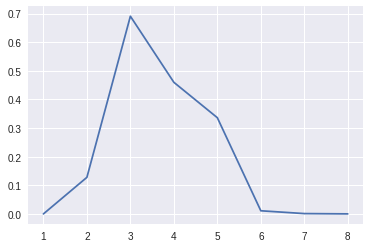

In [85]:
print("iv = %2.4f: %s"%(iv, fp.intepret_iv(iv)))
plt.plot(woeDf.loc[:,"bin_id"], woeDf.loc[:,"info_val"])
